In [50]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [51]:
torch.__version__

'2.0.1'

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
device

device(type='cpu')

In [5]:
# Get some names from https://github.com/MASTREX/List-of-Indian-Names

In [6]:
!wget https://raw.githubusercontent.com/balasahebgulave/Dataset-Indian-Names/master/Indian_Names.csv -O names-long.csv

--2024-03-07 11:57:26--  https://raw.githubusercontent.com/balasahebgulave/Dataset-Indian-Names/master/Indian_Names.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85538 (84K) [text/plain]
Saving to: ‘names-long.csv’

names-long.csv      100%[===================>]  83.53K  --.-KB/s    in 0.08s   

2024-03-07 11:57:26 (1.08 MB/s) - ‘names-long.csv’ saved [85538/85538]



In [54]:
!head names-long.csv

,Name
0,aabid
1,aabida
2,aachal
3,aadesh
4,aadil
5,aadish
6,aaditya
7,aaenab
8,aafreen


In [55]:
!tail names-long.csv

6476,zeshan
6477,zhini
6478,ziarul
6479,zile
6480,zina
6481,zishan
6482,ziyabul
6483,zoya
6484,zuhaib
6485,zuveb


In [56]:
words = pd.read_csv('names-long.csv')["Name"]
words = words.str.lower()
words = words.str.strip()
words = words.str.replace(" ", "")

words = words[words.str.len() > 2]
words = words[words.str.len() < 10]

# Randomly shuffle the words
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

# Remove words having non alphabets
words = [word for word in words if word.isalpha()]
words[:10]


['diti',
 'bajrang',
 'sanjya',
 'nain',
 'mahrul',
 'shib',
 'jashgul',
 'zeba',
 'jaishmin',
 'somil']

In [57]:
len(words)

6184

In [58]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
pprint(itos)

{0: '.',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}


In [75]:
block_size = 5 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

..... ---> d
....d ---> i
...di ---> t
..dit ---> i
.diti ---> .
..... ---> b
....b ---> a
...ba ---> j
..baj ---> r
.bajr ---> a
bajra ---> n
ajran ---> g
jrang ---> .
..... ---> s
....s ---> a
...sa ---> n
..san ---> j
.sanj ---> y
sanjy ---> a
anjya ---> .
..... ---> n
....n ---> a
...na ---> i
..nai ---> n
.nain ---> .
..... ---> m
....m ---> a
...ma ---> h
..mah ---> r
.mahr ---> u
mahru ---> l
ahrul ---> .
..... ---> s
....s ---> h
...sh ---> i
..shi ---> b
.shib ---> .
..... ---> j
....j ---> a
...ja ---> s
..jas ---> h
.jash ---> g
jashg ---> u
ashgu ---> l
shgul ---> .
..... ---> z
....z ---> e
...ze ---> b
..zeb ---> a
.zeba ---> .
..... ---> j
....j ---> a
...ja ---> i
..jai ---> s
.jais ---> h
jaish ---> m
aishm ---> i
ishmi ---> n
shmin ---> .
..... ---> s
....s ---> o
...so ---> m
..som ---> i
.somi ---> l
somil ---> .
..... ---> h
....h ---> a
...ha ---> r
..har ---> i
.hari ---> o
hario ---> m
ariom ---> .
..... ---> f
....f ---> a
...fa ---> r
..far ---> u
.faru ---> k

In [76]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([44325, 5]), torch.int64, torch.Size([44325]), torch.int64)

In [87]:
# Embedding layer for the context

emb_dim = 4
emb = torch.nn.Embedding(len(stoi), emb_dim)


In [88]:
emb.weight

Parameter containing:
tensor([[ 0.7694, -0.0425,  0.4451, -0.5473],
        [-1.4513,  2.3222,  0.5003, -1.9549],
        [-1.2120,  2.3934,  0.3531, -1.4271],
        [-1.1517, -0.7280, -0.9900, -1.0232],
        [ 0.5035, -0.0431, -1.4582,  1.7057],
        [ 1.1632,  0.8851, -0.0941,  0.6955],
        [ 0.7277,  0.8689, -2.3394, -0.1301],
        [ 0.6960,  0.9702,  0.6731,  1.3605],
        [ 0.4484,  0.5055,  0.2673,  0.8483],
        [-1.9781,  0.9819, -1.0400,  0.1364],
        [-0.3586,  0.1020, -0.2296,  0.0335],
        [-0.7084,  0.4625, -0.8382,  0.4765],
        [-0.1664,  0.9483, -0.8406,  1.2484],
        [ 2.3739,  1.0939,  0.3967, -1.0831],
        [ 0.1758,  0.6867, -0.2124, -1.3171],
        [-1.7160,  0.1922, -0.9100,  0.2590],
        [-0.6906,  0.6579, -1.8157,  0.7363],
        [ 0.6869,  1.0605,  0.3869,  2.5261],
        [-1.7279, -0.5944,  0.6080, -2.3156],
        [-0.0682, -0.8245, -0.0153,  1.1720],
        [-0.0647, -1.4478,  0.7775, -0.6562],
        [ 0.

In [89]:
emb.weight.shape

torch.Size([27, 4])

<Axes: >

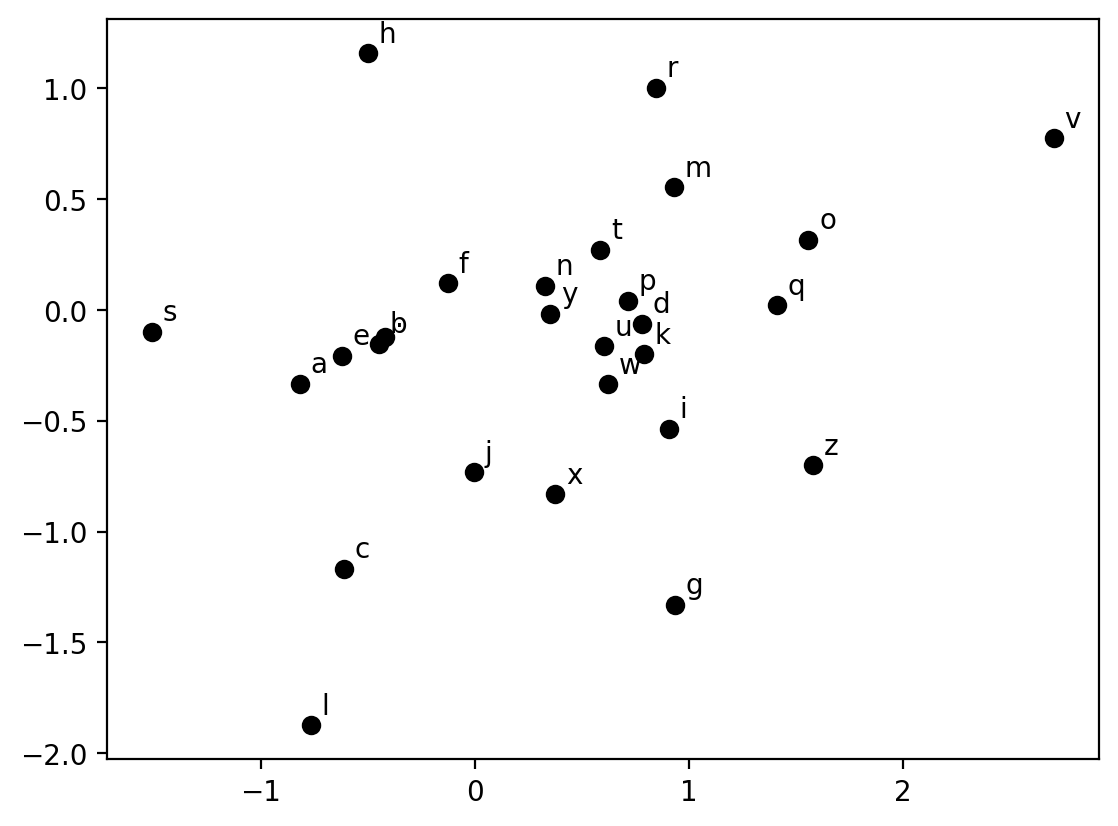

In [80]:
# Function to visualize the embedding in 2d space

def plot_emb(emb, itos, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        x, y = emb.weight[i].detach().cpu().numpy()
        ax.scatter(x, y, color='k')
        ax.text(x + 0.05, y + 0.05, itos[i])
    return ax

plot_emb(emb, itos)

In [90]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.sin(self.lin1(x))
    x = self.lin2(x)
    return x
    

In [91]:
# Generate names from untrained model


model = NextChar(block_size, len(stoi), emb_dim, 10).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_name(model, itos, stoi, block_size, max_len=10):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
        if ch == '.':
            break
        name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_name(model, itos, stoi, block_size))

ecxoxdwsrd
sfeeukszll
nuprryrzgx
gkiktjbsj
govlmjrzgg
llqslrttsz
gw
uchbnxysaj
rwgswujgse
spbohliyft


In [92]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([27, 4])
_orig_mod.lin1.weight torch.Size([10, 20])
_orig_mod.lin1.bias torch.Size([10])
_orig_mod.lin2.weight torch.Size([27, 10])
_orig_mod.lin2.bias torch.Size([27])


In [93]:
# Train the model

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time
# Mini-batch training
batch_size = 4096
print_every = 100
elapsed_time = []
for epoch in range(10000):
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    if epoch % print_every == 0:
        print(epoch, loss.item())


0 2.9544246196746826
100 2.1499083042144775
200 2.136932849884033
300 2.132302761077881
400 2.1297848224639893
500 2.127420425415039


KeyboardInterrupt: 

<Axes: >

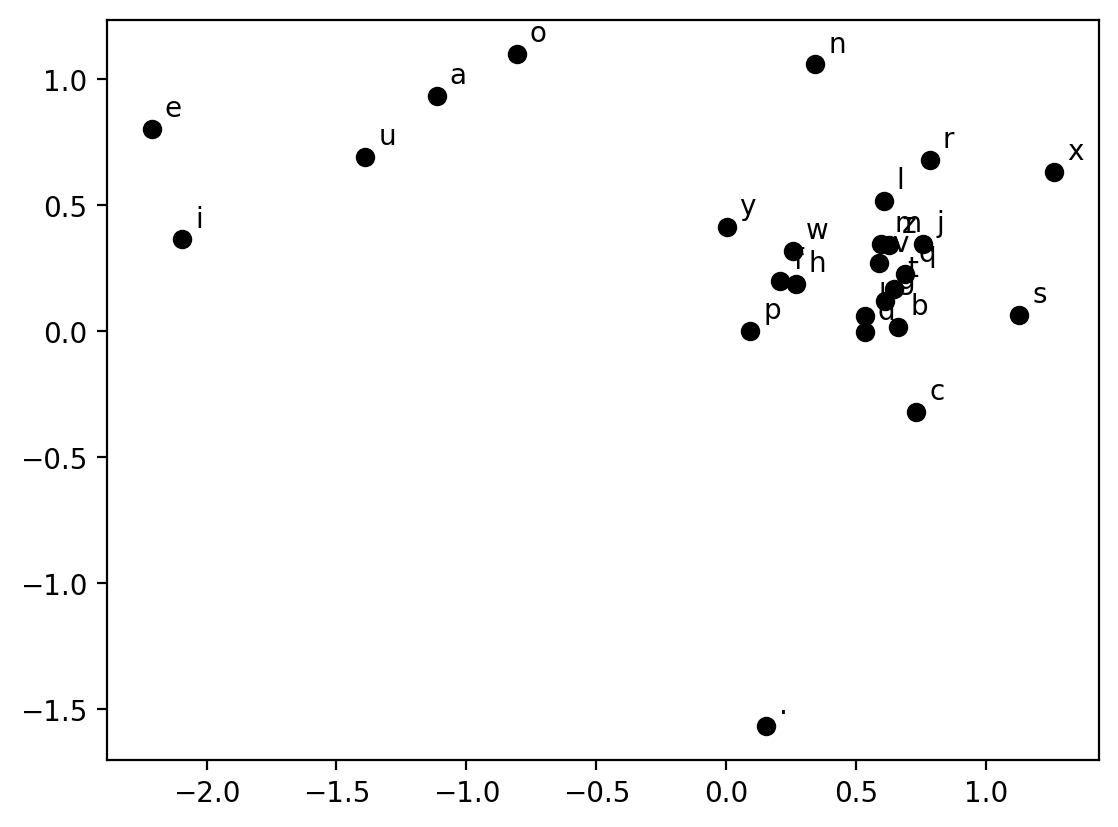

In [85]:
# Visualize the embedding

plot_emb(model.emb, itos)

In [94]:
# Generate names from trained model

for i in range(10):
    print(generate_name(model, itos, stoi, block_size))

koyani
mantit
sukaaki
chawen
shahi
chajil
mahibh
razag
anpara
sabka


Tuning knobs

1. Embedding size
2. MLP 
3. Context length